# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 



---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
validation_file = "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Imports


In [3]:
import time
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline



## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Let's first make sense of the data we have

We are going to start understanding the data, making sense of the classes we have as well as the distribution of 
the samples over the classes 

In [5]:
# Load the sign labels
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)


In [37]:
def group_samples_by_label(lbs_ids, lbs_names):    
    """
    Group the sample by class name 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})
    
    return pd.DataFrame(arr_map)

X_train_labels = group_samples_by_label(y_train, sign_names)
X_train_labels.head(n=3)


,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing


In [38]:
def count_by_labels(samples_by_label):    
    """
    Count by labels
    """
    return pd.pivot_table(samples_by_label,index=["label_id","label_name"],values=["img_id"], aggfunc='count')

X_train_labels_count = count_by_labels(X_train_labels)


Now let's trake the distribution of samples across the different traffic signs.


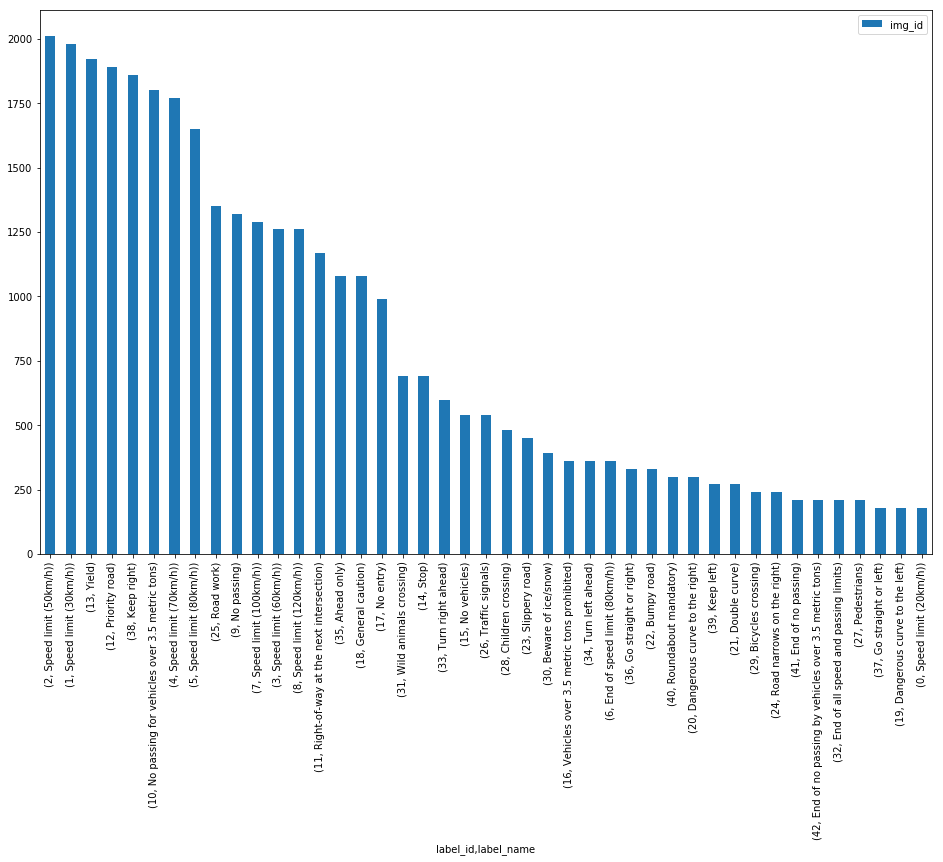

In [39]:
# Plot the chart
X_train_labels_count.sort_values("img_id", ascending=False).plot(kind='bar', figsize=(16, 10))


Finally let's visualize some of the images


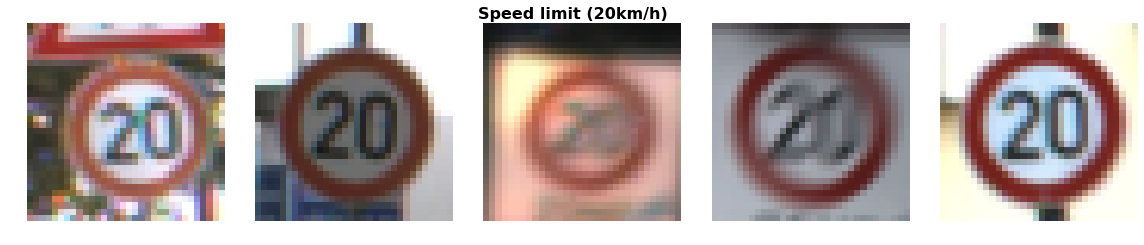

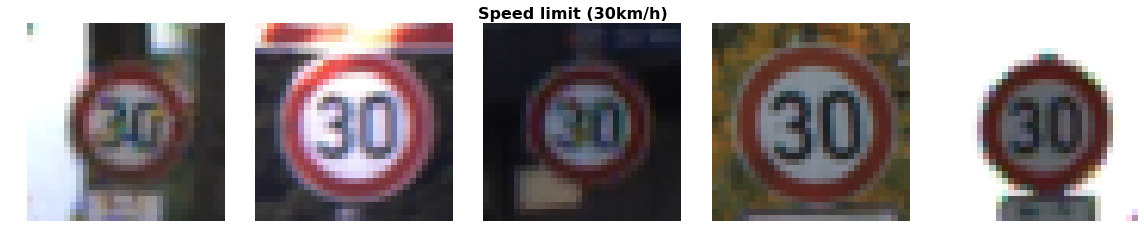

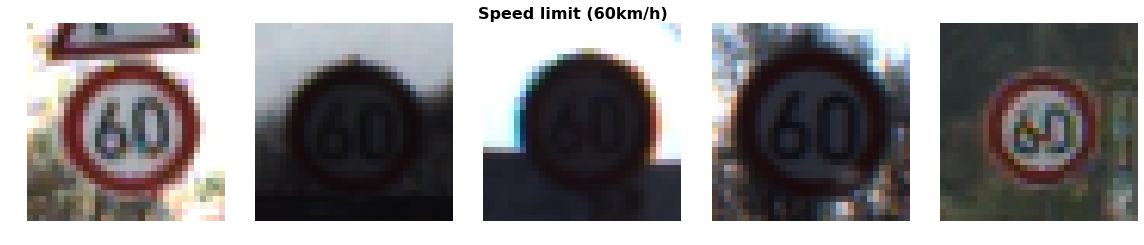

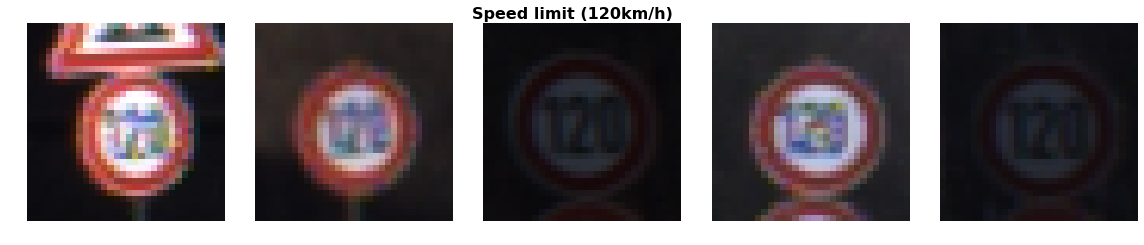

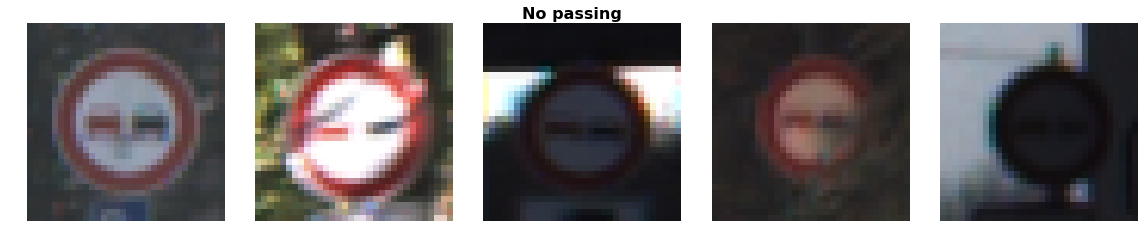

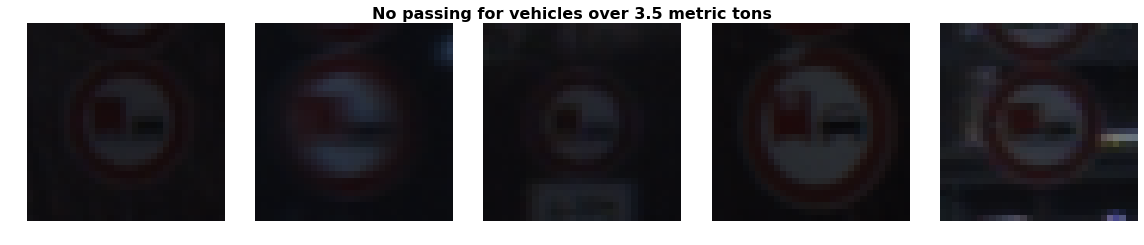

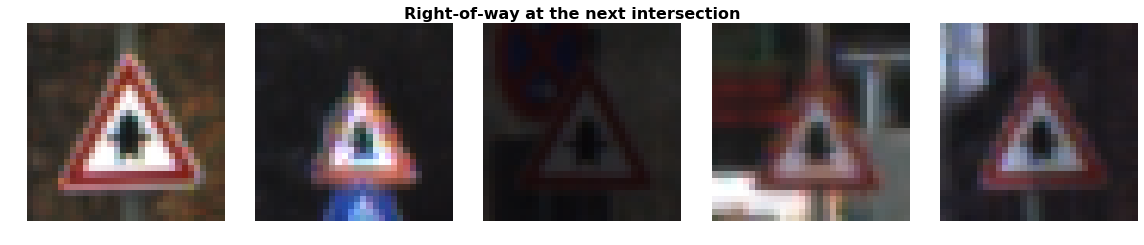

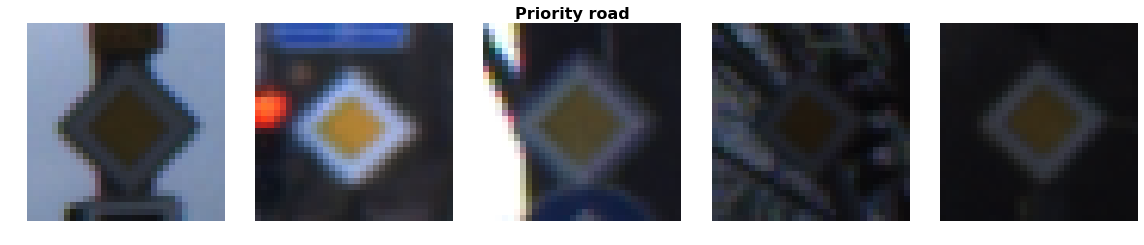

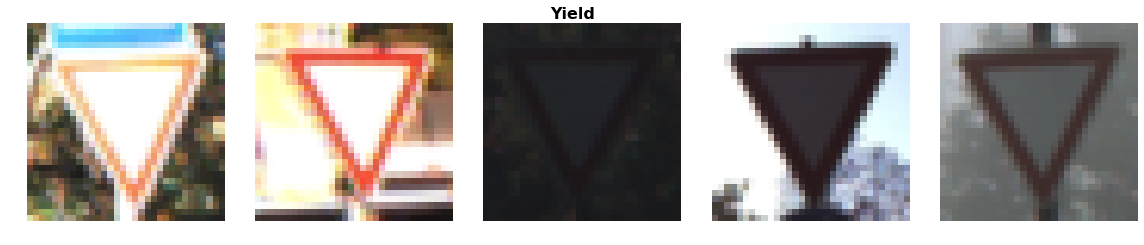

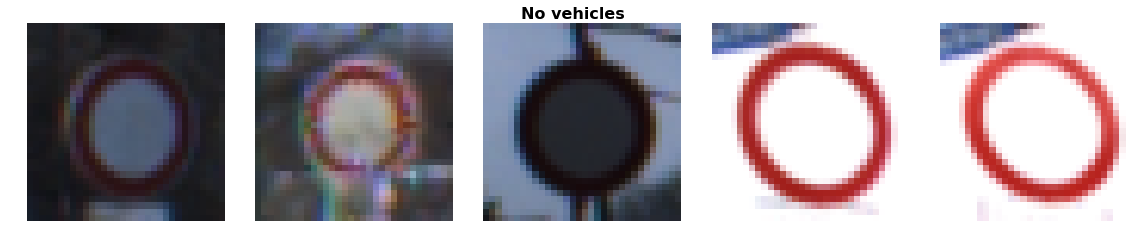

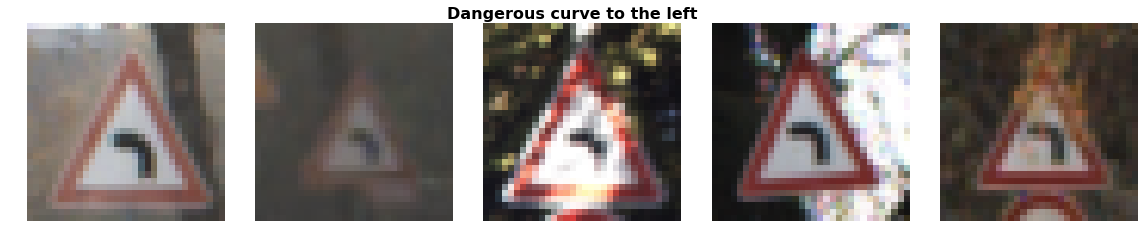

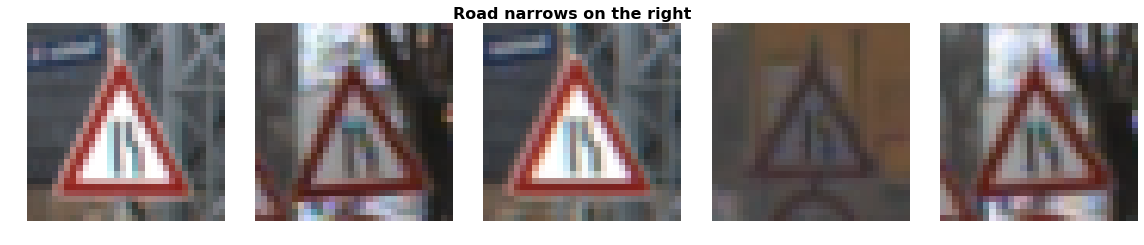

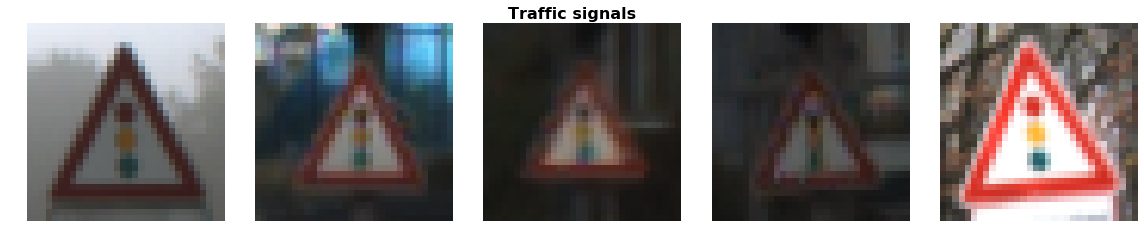

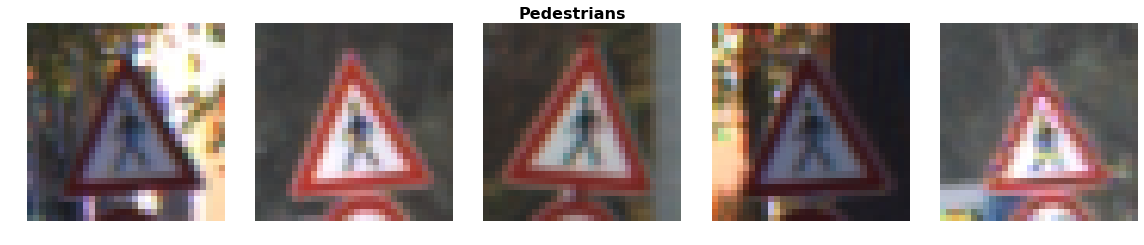

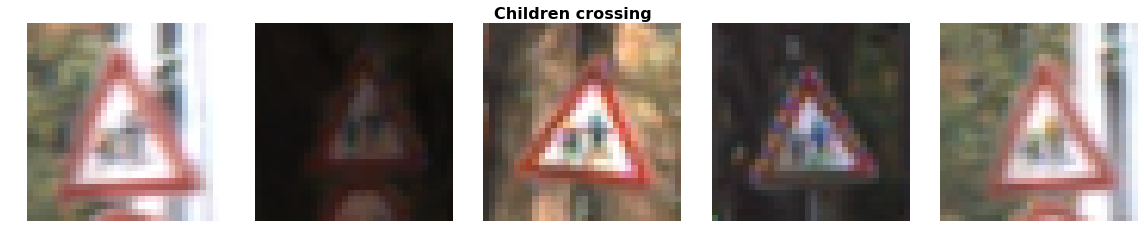

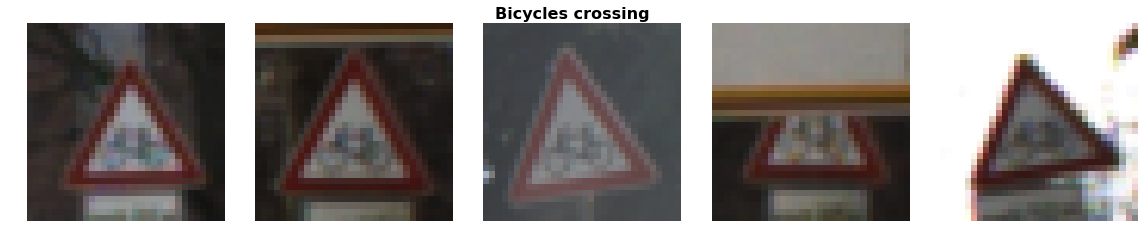

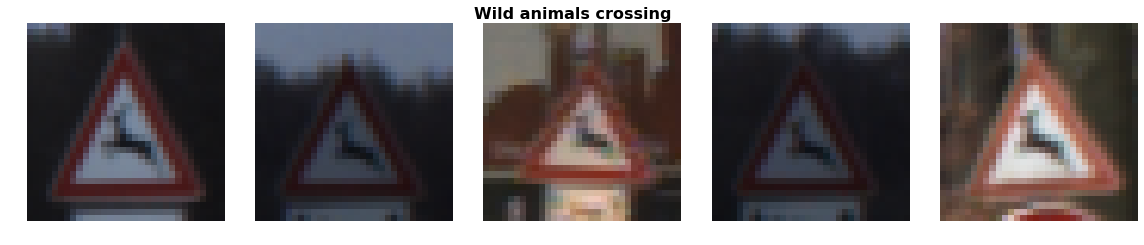

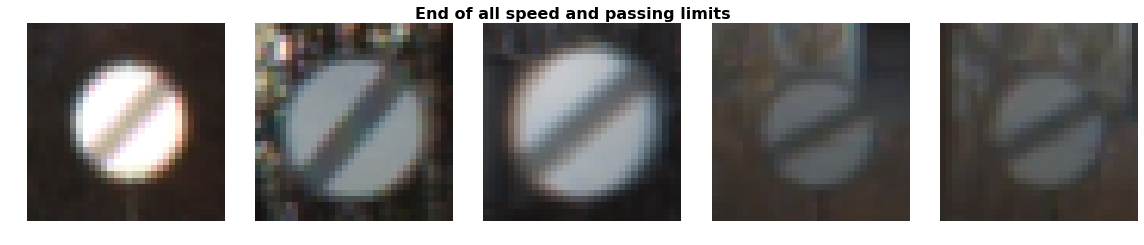

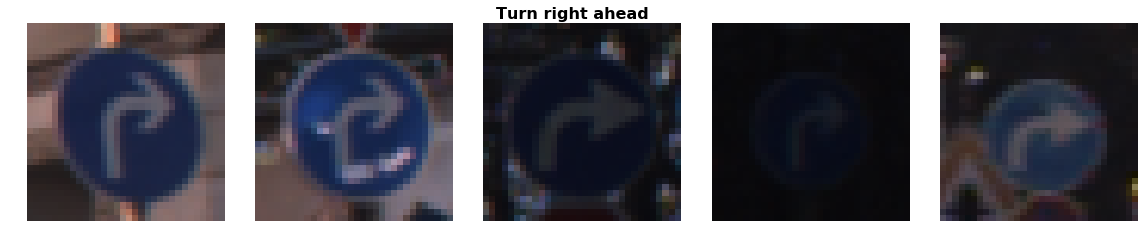

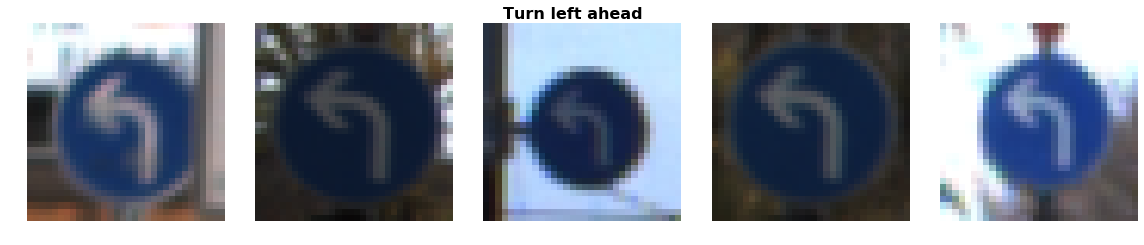

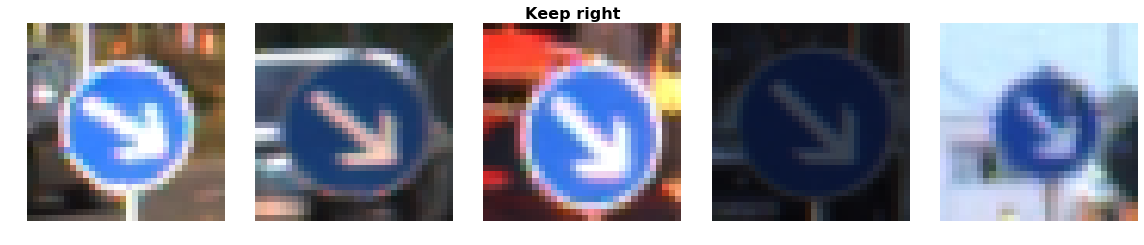

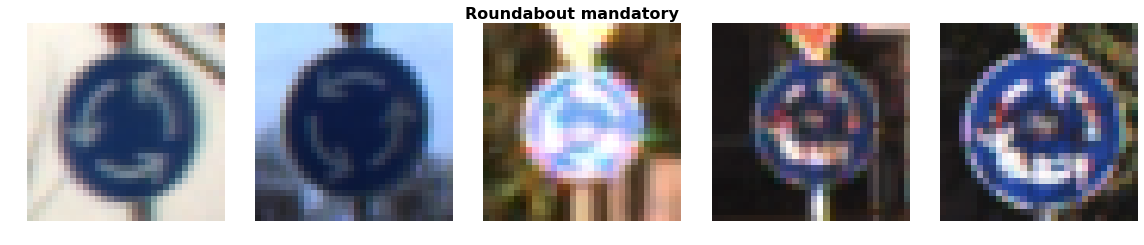

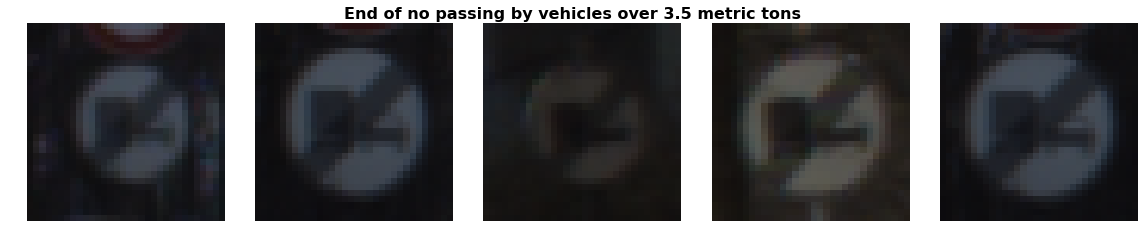

In [44]:
def random_image_plot(labels, imgs, prob_be_shown = 0.5, cols = 5):
    for (label_id, label_name), group in labels:
        if random.random() < prob_be_shown:
            continue
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=cols, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_imgs = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        
        rows = len(selected_imgs) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
        for i, img in enumerate(selected_imgs):
            axes[i].axis("off")
            
            axes[i].imshow(img)
            
        fig.suptitle(label_name, fontsize=16, fontweight='bold', y = 0.6)
        fig.tight_layout()
        plt.show()
        

X_train_labels_group = X_train_labels.groupby(["label_id", "label_name"])
random_image_plot(X_train_labels_group, X_train)



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Normalize
def normalize_imgs(imgs):
    std = np.std(imgs)
    mean = np.mean(imgs)
    return (imgs - mean) / std

X_train_normalized = normalize_imgs(X_train)
X_valid_normalized = normalize_imgs(X_valid)
X_test_normalized = normalize_imgs(X_test)


In [6]:
# Now convert all to greyscale
# X_train_greyscale = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train_normalized]
# X_valid_greyscale = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_valid_normalized]
# X_test_greyscale = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_test_normalized]
# 
# random_image_plot(X_train_labels_group, X_train_greyscale, prob_be_shown=0.2)


### Model Architecture


In [75]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

class TrafficSignNet:
    def __init__(self, learning_rate = 0.001, conv_keep_prob = 0.9, dense_keep_prob=0.75, n_classes = 10):
        """
        Traffic Signs Recognition
        
        :param learning_rate: 
        :param keep_prob: 
        :param n_classes: 
        """
        self.learning_rate = learning_rate
        self.n_classes = n_classes
        self.conv_keep_prob = conv_keep_prob
        self.dense_keep_prob = dense_keep_prob
        self.layer_count = 0
        self.model_stack = []
        # set hyper parameters
        self.mu = 0
        self.sigma = 0.1
        
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope("TrafficSignNet") as scope:
                self.build_model()
                self.saver = tf.train.Saver()
                
    def summary(self):
        def col(text):
            return str(text) + (" " * (10-len(str(text))))
        
        print("TrafficSignNet Model Summary")
        print("-------------------------------------------------------------")
        
        print(col("Layer"), col("type"), col("in_depth"), col("out_depth"), col("filter_size"))
        for layer in self.model_stack:
            print(
                col(layer['layer']), 
                col(layer['type']), 
                col(layer['in_depth']), 
                col(layer['out_depth']), 
                col(layer['filter_size']))
        print("-------------------------------------------------------------")
                
    def _conv(self, x, in_depth, out_depth, filter_size=5):
        """
        Creates a convolution layer
        
        :param x: 
        :param in_depth: 
        :param out_depth: 
        :param filter_size: 
        :return: convolution layer
        """
        self.layer_count += 1
        self.model_stack.append({
            'layer': self.layer_count,
            'type': 'conv',
            'in_depth': in_depth,
            'out_depth': out_depth,
            'filter_size': 5
        })
        
        conv_w = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, in_depth, out_depth), mean=self.mu, stddev=self.sigma))
        conv_b = tf.Variable(tf.zeros(out_depth))
        conv = tf.nn.conv2d(x, conv_w, strides=[1, 1, 1, 1], padding='VALID') + conv_b
        conv = tf.nn.relu(conv)
        
        # Max pooling 
        conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Dropout
        conv = tf.nn.dropout(conv, self.conv_keep_prob) 
        
        return conv
    
    def _dense(self, x, units, last=False):
        """
        Creates a dense layer
        
        :param x: 
        :param units: 
        :return: dense layer
        """
        self.layer_count += 1
        self.model_stack.append({
            'layer': self.layer_count,
            'type': 'dense',
            'in_depth': x.get_shape().as_list()[-1],
            'out_depth': units,
            'filter_size': None
        })
        
        dense_w = tf.Variable(tf.truncated_normal(shape=(x.get_shape().as_list()[-1], units), mean=self.mu, stddev=self.sigma)) 
        dense_b = tf.Variable(tf.zeros(units))
        dense = tf.matmul(x, dense_w) + dense_b
        if last:
            return dense
        
        dense = tf.nn.relu(dense)
        
        return tf.nn.dropout(dense, self.dense_keep_prob)
        
            
    def build_model(self):
        """
        Builds an LeNet model 
         
        :return: model 
        """
        self.x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.y = tf.placeholder(tf.int32, (None))
        self.one_hot_y = tf.one_hot(self.y, self.n_classes)        
        
        layer_1 = self._conv(self.x, in_depth=3, out_depth=32, filter_size=5)
        layer_2 = self._conv(layer_1, in_depth=32, out_depth=64, filter_size=5)
        
        layer_3 = flatten(layer_2)
        layer_4 = self._dense(layer_3, units=120)
        layer_5 = self._dense(layer_4, units=84)
        self.logits = self._dense(layer_5, units=self.n_classes, last=True)
        
        
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.prediction = tf.argmax(input=self.logits, axis=1)
        self.prediction_top5 = tf.nn.top_k(tf.nn.softmax(self.logits), 5)
    
    def evaluate(self, X_data, Y_data, batch_size):
        """
        Evaluates the model accuracy and loss
        
        :param X_data: 
        :param Y_data: 
        :param batch_size: 
        :return: accuracy, loss
        """
        num_examples = len(X_data)
        total_loss = 0.0
        total_accuracy = 0.0
        sess = tf.get_default_session()
        
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            loss = sess.run(self.loss_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            
            total_accuracy += (accuracy * len(batch_x))
            total_loss += (loss * len(batch_x))
            
        return total_accuracy / num_examples, total_loss / num_examples
    
    def train(self, train_features, train_labels, valid_features, valid_labels, epochs = 10, batch_size = 100):
        """
        Trains the model for the given data
        
        :param X_train: 
        :param Y_train: 
        :param epochs: 
        :param batch_size: 
        :return: None
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(train_features)
            
            print("Training...")
            print()
            for i in range(epochs):
                start_time = time.time()
                x_train_features, y_train_labels = shuffle(train_features, train_labels)
                
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = x_train_features[offset:end], y_train_labels[offset:end]
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y}) 
                    
                train_accuracy, train_loss = self.evaluate(train_features, train_labels, batch_size)
                valid_accuracy, valid_loss = self.evaluate(valid_features, valid_labels, batch_size)
                
                if i == 0 or (i+1) % 10 == 0:
                    print("[{}]\t time={:.3f}s | train: [loss: {:.4f} acc={:.4f}] | valid: [loss: {:.4f} acc={:.4f}]".format(
                        i+1, 
                        time.time()-start_time, 
                        train_loss, 
                        train_accuracy, 
                        valid_loss, 
                        valid_accuracy))
                
            self.saver.save(sess, './model/TrafficSignNet')
            print("Model saved!")
        
    def test(self, test_features, test_labels, batch_size = 100):
        """
        Evaluates the model with the given test data
        
        :param test_features: 
        :param test_labels: 
        :param batch_size: 
        :return: accuracy, loss
        """
        with tf.Session(graph=self.graph) as sess:
            tf.global_variables_initializer()
            
            self.saver.restore(sess, "./model/TrafficSignNet")

            start = time.time()
            test_accuracy, test_loss = self.evaluate(test_features, test_labels, batch_size)
            print("[Test Set]\ttime={:.3f}s, loss={:.4f}, acc={:.4f}".format(time.time() - start, test_loss, test_accuracy))

        
        return test_accuracy, test_loss
    
    def predict(self, img):
        """
        Predict the right class
        
        :param img: 
        :return: classification
        """
        with tf.Session(graph=self.graph) as sess:
            tf.global_variables_initializer()
            
            self.saver.restore(sess, "./model/TrafficSignNet")

            return sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                })
        
    def predict_top5(self, img):
        """
        Predict the top 5 classes for the image
        
        :param img: 
        :return: top 5 classifications
        """
        with tf.Session(graph=self.graph) as sess:
            tf.global_variables_initializer()
            
            self.saver.restore(sess, "./model/TrafficSignNet")

            return sess.run(self.prediction_top5, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                })
        
        
    

### Train, Validate and Test the Model

First we are going to display a model summary


In [76]:

model = TrafficSignNet(learning_rate=0.001, conv_keep_prob=0.9, dense_keep_prob=0.75, n_classes=n_classes)
model.summary()


TrafficSignNet Model Summary
-------------------------------------------------------------
Layer      type       in_depth   out_depth  filter_size
1          conv       3          32         5         
2          conv       32         64         5         
3          dense      1600       120        None      
4          dense      120        84         None      
5          dense      84         43         None      
-------------------------------------------------------------


Now let's train the model, if the model has already been trained you may skipped this section


In [12]:
sample_size = len(X_train)
print("Sample Size", sample_size)
X_train_sample = X_train_normalized[:sample_size,]
Y_train_sample = y_train[:sample_size,]
X_valid_sample = X_valid_normalized[:sample_size,]
Y_valid_sample = y_valid[:sample_size,]
model.train(X_train_sample, Y_train_sample, X_valid_sample, Y_valid_sample, epochs=100, batch_size=512)


Sample Size 34799
Training...

[1]	 time=8.465s | train: [loss: 2.2208 acc=0.3922] | valid: [loss: 2.4274 acc=0.3401]
[10]	 time=5.894s | train: [loss: 0.1186 acc=0.9634] | valid: [loss: 0.4048 acc=0.8961]
[20]	 time=5.928s | train: [loss: 0.0462 acc=0.9874] | valid: [loss: 0.3083 acc=0.9272]
[30]	 time=5.921s | train: [loss: 0.0257 acc=0.9929] | valid: [loss: 0.3229 acc=0.9388]
[40]	 time=5.928s | train: [loss: 0.0219 acc=0.9947] | valid: [loss: 0.3318 acc=0.9456]
[50]	 time=5.905s | train: [loss: 0.0126 acc=0.9959] | valid: [loss: 0.3237 acc=0.9463]
[60]	 time=5.914s | train: [loss: 0.0200 acc=0.9937] | valid: [loss: 0.3451 acc=0.9497]
[70]	 time=5.918s | train: [loss: 0.0101 acc=0.9966] | valid: [loss: 0.3660 acc=0.9567]
[80]	 time=5.895s | train: [loss: 0.0102 acc=0.9974] | valid: [loss: 0.3137 acc=0.9492]
[90]	 time=5.956s | train: [loss: 0.0112 acc=0.9971] | valid: [loss: 0.3203 acc=0.9465]
[100]	 time=5.904s | train: [loss: 0.0091 acc=0.9974] | valid: [loss: 0.3769 acc=0.9512]
M

Now let's evaluate the model against our test data to see it's accuracy


In [77]:
test_accuracy, test_loss = model.test(X_test_normalized, y_test)


INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
[Test Set]	time=8.721s, loss=0.4532, acc=0.9417


---

## Step 3: Test a Model on New Images

Next we are going to load some sample images and see what our predictions are


INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet


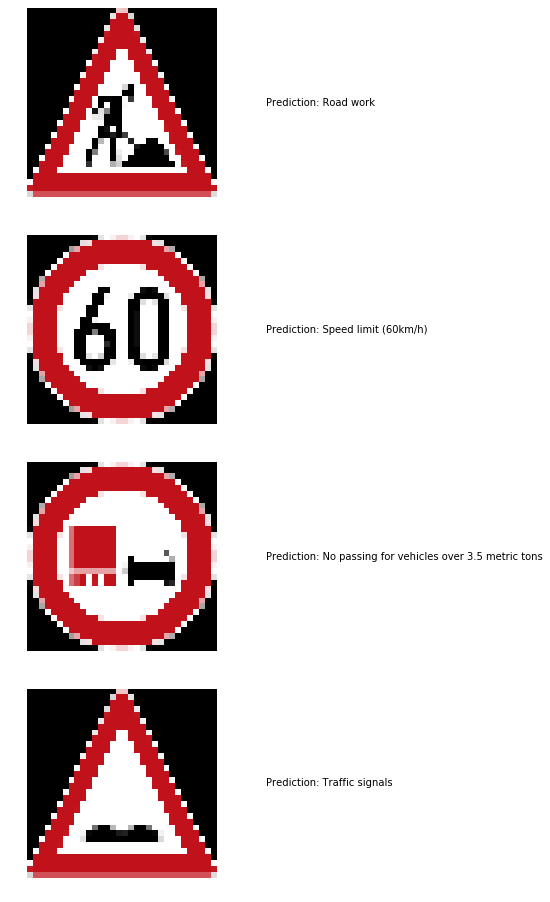

In [78]:
import glob

example_images = []
example_images_label = []
example_images_label_top5 = []
files = glob.glob("examples/*.png")

fig, axes = plt.subplots(len(files), 1, figsize=(16, 16))
for i, img in enumerate(files):
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    n = cv2.resize(n, (32, 32))
    example_images.append(n)
    
    nn = normalize_imgs([n])[0]
    pred = model.predict(nn)
    example_images_label.append(sign_names.loc[pred[0]]["SignName"])
    example_images_label_top5.append(model.predict_top5(nn))
    
    axes[i].imshow(n)
    axes[i].axis('off')
    axes[i].annotate("Prediction: " + sign_names.loc[pred[0]]["SignName"],
                     xy=(8,8), xytext=(40,16))
    
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Let's now take a deeper look into the classification trying to predict the top 5 classes per image



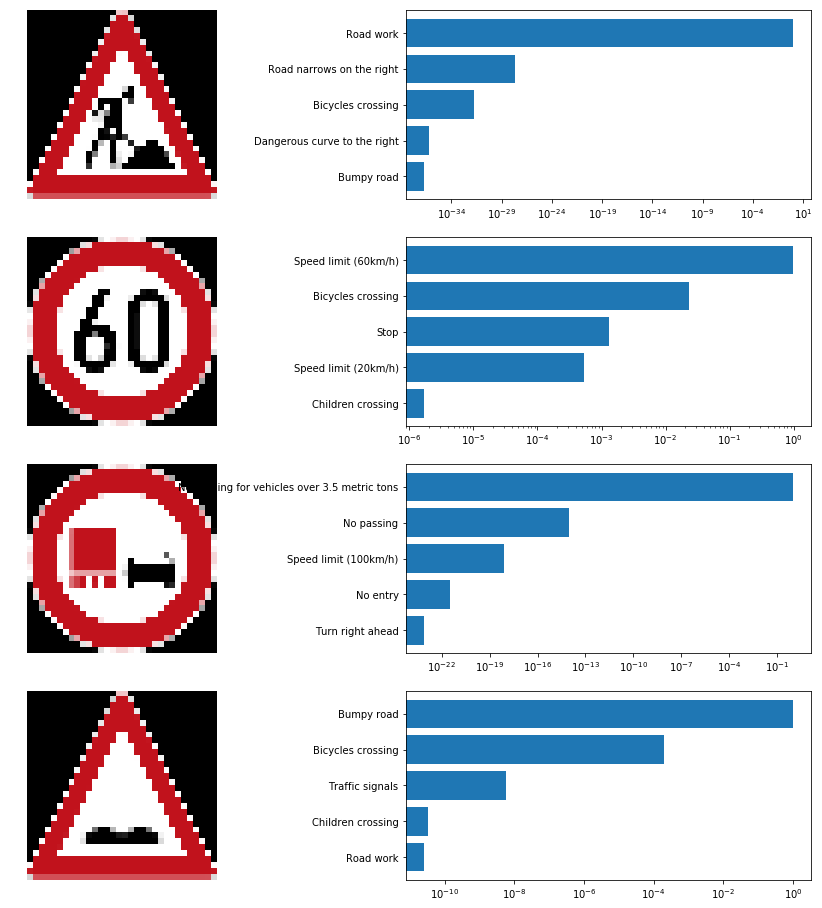

In [81]:
fig, axes = plt.subplots(len(example_images), 2, figsize=(16, 16))
for i, img in enumerate(example_images):
    axes[i][0].imshow(img)
    axes[i][0].axis('off')
    
    labels = [sign_names.loc[s]["SignName"] for s in example_images_label_top5[i].indices[0]]
    
    y_pos = np.arange(5)
    axes[i][1].barh(y_pos, example_images_label_top5[i].values[0])
    axes[i][1].invert_yaxis()
    axes[i][1].set_yticks(y_pos, minor=False)
    axes[i][1].set_yticklabels(labels)
    axes[i][1].set_xscale('log')



In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")